# 🚀 Aula Aberta de DQN
> Ensinando um módulo a pousar na Lua com redes neurais!
>
> Você pode checar os slides da aula [aqui](../Deep%20Q-Networks%20(DQN).pdf)

## Importando as bibliotecas necessárias

In [1]:
!pip install torch # Necessário para criar redes neurais
!pip install gym[box2d] # Necessário para nossos ambientes

In [39]:
import gym
import math
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Replay Buffer

In [ ]:
import numpy as np

class ReplayBuffer:
    """Experience Replay Buffer para DQNs."""
    def __init__(self, max_length, observation_space):
        """Cria um Replay Buffer.

        Parâmetros
        ----------
        max_length: int
            Tamanho máximo do Replay Buffer.
        observation_space: int
            Tamanho do espaço de observação.
        """

        # Crie os atributos self.index, self.size e os atribua o valor 0
        self.index = 0
        self.size = 0

        # Crie o atributo self.max_length que recebe o valor do parâmetro
        self.max_length = max_length

        # Utilizando a função np.zeros inicialize a memória para cada variável com o formato indicado:
        # self.states - formato(max_length, observation_space), array de np.float32
        self.states = np.zeros((max_length, observation_space), dtype=np.float32)
        # self.actions - formato(max_length), array de np.int32
        self.actions = np.zeros(max_length, dtype=np.int32)
        # self.rewards - formato(max_lenght), array de np.float32
        self.rewards = np.zeros(max_length, dtype=np.float32)
        # self.next_states - formato(max_lenght, observation_space), array de np.float32
        self.next_states = np.zeros((max_length, observation_space), dtype=np.float32)
        # self.dones - formato(max_length), array de np.int32
        self.dones = np.zeros(max_length, dtype=np.int32)

    def __len__(self):
        """Retorna o tamanho do buffer."""
        # Retorna o atributo self.size
        return self.size

    def update(self, state, action, reward, next_state, done):
        """Adiciona uma experiência ao Replay Buffer.

        Parâmetros
        ----------
        state: np.array
            Estado da transição.
        action: int
            Ação tomada.
        reward: float
            Recompensa recebida.
        state: np.array
            Estado seguinte.
        done: int
            Flag indicando se o episódio acabou.
        """

        # Para cada array de cada parâmetro, adicione o parâmetro ao array no índice self.index
        self.states[self.index] = state
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.next_states[self.index] = next_state
        self.dones[self.index] = done

        # Incrementa o índice e atualiza o tamanho
        self.index = (self.index + 1) % self.max_length
        if self.size < self.max_length:
            self.size += 1

    def sample(self, batch_size):
        """Retorna um batch de experiências.
        
        Parâmetros
        ----------
        batch_size: int
            Tamanho do batch de experiências.
        Retorna
        -------
        states: np.array
            Batch de estados.
        actions: np.array
            Batch de ações.
        rewards: np.array
            Batch de recompensas.
        next_states: np.array
            Batch de estados seguintes.
        dones: np.array
            Batch de flags indicando se o episódio acabou.
        """

        # Utilizando a função np.random.randint(), atribua a variável idxs 
        # um array de tamanho batch_size, com números aleatórios entre 0 e self.size
        idxs = np.random.randint(0, self.size, size=batch_size)

        # Para cada elemento da observação, retorne um batch de elementos que estão nos
        # índices idxs de cada array de memória
        return(self.states[idxs], self.actions[idxs], self.rewards[idxs], self.next_states[idxs], self.dones[idxs])

## Conhecendo nosso ambiente

In [20]:
env = gym.make("LunarLander-v2")

print(f"Formato das observações do nosso agente: {env.observation_space.shape} | Uma possível observação: {env.observation_space.sample()}")
print(f"Número de possíveis ações: {env.action_space.n} | Uma possível ação: {env.action_space.sample()}")

env.close()

Formato das observações do nosso agente: (8,) | Uma possível observação: [ 0.8091425  -1.135604    2.359145   -0.7932247  -1.6031862   0.41732824
 -0.77799165 -0.60098314]
Número de possíveis ações: 4 | Uma possível ação: 1


Como estão configuradas as recompensas:
  - Se a nave pousar ela recebe uma recompensa de $+100$
  - Cada perna que entra em contato com o solo o agente recebe $+10$
  - Acionar as engines faz com que ele receba uma penalidade de $-0.3$ por frame
  - O estado terminal ocorre quando ou o agente morre, recebendo uma penalidade de $-100$ ou quando acaba o tempo da simulação, recebendo mais uma recompensa de $+100$ se estava pousado no alvo.

### Criando um agente aleatório
Só para ver se está tudo funcionando corretamente

In [13]:
def random_env():

    env = gym.make("LunarLander-v2")

    state = env.reset()

    done = False

    while not done:

        action = env.action_space.sample()

        next_state, reward, done, _ = env.step(action)

        env.render()

        state = next_state

    env.close() 

In [15]:
random_env()

## Rede Neural

In [18]:
class LinearNetwork(nn.Module):
    """
    Cria uma rede neural para DQN
    """
    def __init__(self, in_dim, out_dim):
        """
        Inicializa a rede
        
        Parâmetros
        ----------
        in_dim: int
        Dimensão de entrada da rede, ou seja, o shape do estado do ambiente
        
        out_dim: int
        Número de ações do agente neste ambiente
        
        Retorna
        -------
        None
        """
        super(LinearNetwork, self).__init__()

        # Cire um atributo self.layers com nossa rede neural utilizando a função nn.Sequential
        # A estrutura da rede deve ser:
        # Linear(in_dim, 128) -> ReLU() -> Linear(128,128) -> ReLU() -> Linear(128, out_dim)

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        """
        Propaga uma entrada pela rede
        """
        return self.layers(x)

## Criando nosso agente

In [55]:
class DQNagent:
    """
    Uma classe que cria um agente DQN que utiliza ReplayBuffer como memória
    """
    def __init__(self, 
                 observation_space, 
                 action_space, 
                 lr=3e-4, 
                 gamma=0.9, 
                 max_memory=10000,
                 epsilon_init=0.5,
                 epsilon_decay=0.995,
                 epsilon_min=0.01,
                 epochs=1):
      
        """
        Inicializa o agente com os parâmetros dados
        
        Parâmetros
        ----------
        
        observation_space: gym.spaces
        O espaço de observação do gym
         
        action_space: gym.spaces
        O espaço de ações do agente modelado no gym
        
        lr: floar, default=3e-4
        A taxa de aprendizado do agente
        
        gamma: float, default=0.99
        O fator de desconto. Se perto de 1. as recompensas futuras terão grande importância,
        se perto de 0. as recompensas mais instantâneas terão maior importância
        
        max_memory: int, default=100000
        O número máximo de transições armazenadas no buffer de memória
        
        epsilon_init: float, default=0.5
        O epsilon inicial do agente. Se próximo de 1. o agente tomará muitas ações
        aleatórias, se proóximo de 0. o agente escolherá as ações com maior
        Q-valor
        
        epsilon_decay: float, default=0.9995
        A taxa de decaimento do epsilon do agente. A cada treinamento o agente tende
        a escolher meno ações aleatórias se epsilon_decay<1
        
        min_epsilon: float, default=0.01
        O menor epsilon possível
        
        
        network: str, default='linear'
        O tipo de rede a ser utilizada para o agente DQN. Por padrão é usada uma rede linear, mas
        pode ser usada uma rede convolucional se o parâmetro for 'conv'
        
        Retorna
        -------
        None
        """
        # Inicialize o atributo de self.device com o método torch.device, se possível utlize cuda,
        # caso contrário utilize uma cpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using: {self.device}")
        # Inicialize o atributo self.gamma
        self.gamma = gamma
        # Inicialize o atributo self.memory inicializando um objeto ReplayBuffer()
        self.memory = ReplayBuffer(max_memory, observation_space.shape[0])
        # Inicialize o atributo self.action_space
        self.action_space = action_space
        # Inicialize o atributo self.epoch
        self.epochs = epochs

        # Inicialize os atributo self.epsilon, self.epsilon_decay e self.espilon_min
        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Inicialize o atributo de self.dqn com nosso objeto LinearNetwork(),
        # utilize também o método .to(self.device)
        self.dqn = LinearNetwork(observation_space.shape[0], action_space.n).to(self.device)

        # Inicialize o atributo self.optimizer com o optimizador optim.Adam() que optimiza o
        # self.dqn.parameters() com um learning rate lr
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)

    def act(self, state, greedy=False):
        """
        Método para o agente escolher uma ação
        
        Parâmetros
        ----------
        
        state
        O estado do agente
        
        Retorna
        -------
        
        action
        A ação escolhida pelo agente
        """

        # Utilize do algoritmo epsilon-greedy:
        # se um número criado pela função np.random.random() for menor
        # que nosso epsilon e greedy for Falso, execute uma ação aleatória
        if np.random.random() < self.epsilon and not greedy:
            action = self.action_space.sample()
        else:
            with torch.no_grad():   # Utilizamos no_grad já que não iremos optimzar esses parâmetros agora
                # Transforme o parâmetro state em um torch.FloatTensor(), utilize o método .to(self.device)
                state = torch.FloatTensor(state).to(self.device)
                # Passe o state para nossa DQN pelo seu método forward e colete a ação de maior valor com
                # o método .argmax(dim=-1)
                action = self.dqn.forward(state).argmax(dim=-1)
                # Transforme a ação em um valor numpy com os métodos ação.cpu().numpy()
                action = action.cpu().numpy()

        return action

    def eps_decay(self):
        """
        Método para aplicar o decaimento do epsilon
        """


        # Se self.epsilon for maior que o self.epsilon_min,
        # self.epsilon = self.epsilon * self.epsilon_decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, next_state, done):
        """
        Método para armazenar uma sequência estado, ação, recompensa, próximo estado e done
        no buffer de memória
        """

        # utilizando o método .update do nosso ReplaBuffer, passe os parâmetros à nossa memória
        self.memory.update(state, action, reward, next_state, done)

    def train(self, batch_size, save=False):
        """ 
        Método para treinar o agente
        """

        # se batch_size * 10 for menor que o tamanho de nossa memória, a a gente não deve treinar
        if batch_size * 10 > self.memory.size:
            return

        for epoch in range(self.epochs):
            # Colete um batch de experiências com o método .sample da nossa memória
            states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

            # Transforme cada atributo da nossa memória em um tensor, para as actions,
            # rewards, e dones utilize o método .unsqueeze(-1) para colocá-los no formato certo
            states = torch.as_tensor(states).to(self.device)
            actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1) 
            rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1) 
            next_states = torch.as_tensor(next_states).to(self.device)
            dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)


            # Para obter nossos Q valores passe os states para nossa DQN pelo método .forward(),
            # Utilize também o método .gather(-1, actions.long()) após o forward para obter os q valores
            q = self.dqn.forward(states).gather(-1, actions.long())

            with torch.no_grad():   # Utilizamos o no_grad pois esse q vamos usar para a loss, não precisa dos gradientes
                # Obtenha o Q2 passando os next_states para nossa DQN pelo método .forward(),
                # utilize depois o método .max(dim=-1, keepdim=True)[0]
                q2 = self.dqn.forward(next_states).max(dim=-1, keepdim=True)[0]

                # Calcule o target com a fórmula (rewards + (1 - dones) * self.gamma * q2)
                target = (rewards + (1 - dones) * self.gamma * q2).to(self.device)

            # Calcule a loss
            loss = F.mse_loss(q, target)
            # Realize as etapas de optimização
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if save:
            self.save_model()

    def save_model(self, model_file):
        torch.save(self.dqn.state_dict(), model_file)
        print(f"\n Model saved: {model_file}")

    def load_model(self, model_file):
        self.dqn.load_state_dict(torch.load(model_file))
        print(f"Model loaded: {model_file}")

### O que o método unsqueeze() faz?
Basicamente ele insere uma dimensão de valor um em alguma dimensão especificada de um tensor, exemplos:

In [5]:
a = torch.as_tensor([[1,2,3],[4,5,6]])
print(f"Tensor sem unsqueeze: \n{a}\n"
      f"Formato do tensor sem unsqueeze {a.shape}")

Tensor sem unsqueeze: 
tensor([[1, 2, 3],
        [4, 5, 6]])
Formato do tensor sem unsqueeze torch.Size([2, 3])


In [10]:
b = a.unsqueeze(-1)
print(f"Tensor com unsqueeze: \n{b}\n"
      f"Formato do tensor com unsqueeze {b.shape}")

Tensor com unsqueeze: 
tensor([[[1],
         [2],
         [3]],

        [[4],
         [5],
         [6]]])
Formato do tensor com unsqueeze torch.Size([2, 3, 1])


### O que o método gather() faz?
Basicamente ele criar um tensor novo pegando os valores de um tensor (no nosso caso actions.long()) e os utilizando como índices para pegar valores do tensor de origem (saída de nossa rede neural). o parâmetro dim é utilziado para indicar por qual dimensão do tensor de índice deve ser percorrido.

![img](https://i.stack.imgur.com/nudGq.png)

In [52]:
def train(agent, env, timesteps, batch_size, render=False):
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []
    episode = 0
    state = env.reset()

    for timestep in range(1, timesteps + 1):
        action = agent.act(state)

        # Tomar a ação escolhida
        next_state, reward, done, info = env.step(action)

        # Guardar as informações geradas pela ação
        agent.remember(state, action, reward, next_state, done)

        # Treinar a rede com base no ReplayBuffer
        agent.train(batch_size, False)

        # Soma as recompensas
        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()

        agent.eps_decay()

        if episode_returns:
            avg_returns.append(np.mean(episode_returns))

        total_reward *= 1 - done
        ratio = math.ceil(100 * timestep / timesteps)
        avg_return = avg_returns[-1] if avg_returns else np.nan

        # Atualiza o estado
        state = next_state

        if render:
            # Mostra o ambiente
            env.render()

        print(
            f"\r[{ratio:3d}%]",
            f"timestep = {timestep}/{timesteps}",
            f"episode = {episode:3d}",
            f"avg_return = {avg_return:10.4f}",
            f"eps = {agent.epsilon:.4f}",
            sep=", ",
            end="")

    env.close()
    return avg_returns

## Treinando o agente

In [53]:
BATCH_SIZE = 256
GAMMA = 0.99
EPS_INIT = 1
EPS_END = 0.001
EPS_DECAY = 0.99995
MAX_MEMORY = 1_000_000
TIMESTEPS = 150_000
EPOCHS = 1

env_name = 'LunarLander-v2'
env = gym.make(env_name)
OBS_SPACE = env.observation_space
ACT_SPACE = env.action_space

print("\nTraining DQN")
dqn_net = DQNagent(observation_space=OBS_SPACE,
                    action_space=ACT_SPACE,
                    lr=3e-4,
                    gamma=GAMMA,
                    max_memory=MAX_MEMORY,
                    epsilon_init=EPS_INIT,
                    epsilon_decay=EPS_DECAY,
                    epsilon_min=EPS_END,
                    epochs=EPOCHS)


results_dqn = train(dqn_net, env, TIMESTEPS, BATCH_SIZE, render=False)


Training DQN
Using: cpu
[100%], timestep = 150000/150000, episode = 313, avg_return =   237.2787, eps = 0.0010

## Checando os resultados

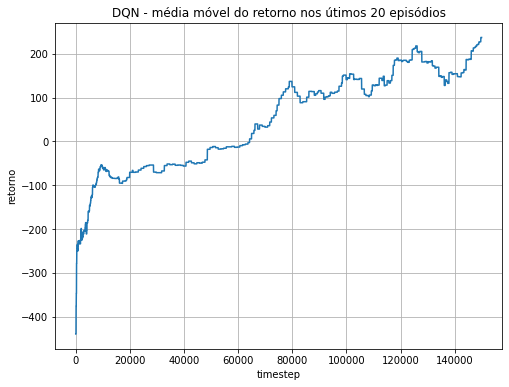

In [54]:
# Plota os resultados
plt.figure(figsize=(8,6))
plt.plot(results_dqn)
plt.title('DQN - média móvel do retorno nos útimos 20 episódios')
plt.xlabel('timestep')
plt.ylabel('retorno')
plt.grid()
plt.show()

In [56]:
def test(agent, env, episodes):
    for episode in range(episodes):
        done = 0
        state = env.reset()
        total_reward = 0

        while not done:
            action = agent.act(state, greedy=True)
            state, reward, done, _ = env.step(action)
            env.render()
            total_reward += reward

            print(f"\r {total_reward:3.3f}", end="")
        
    env.close()

In [ ]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
test(dqn_net, env, 5)